# Human-Mammalian Brain - Basal Ganglia 10X snRANSeq analysis: gene expression

[Intro text]

You need to be connected to the internet to run this notebook or connected to a cache that has the HMBA-BG data downloaded already.

The notebook presented here shows quick visualizations from precomputed metadata in the atlas. For examples on accessing the expression matrices, specifically selecting genes from expression matrices, see the ``general_acessing_10x_snRNASeq_tutorial.ipynb tutorial/example``.

In [1]:
from unittest.mock import patch

import pandas as pd
import numpy as np
import anndata
from pathlib import Path
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from abc_atlas_access.abc_atlas_cache.anndata_utils import get_gene_data

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas DataFrame. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been. 

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
# download_base = Path('../../data/abc_atlas')
download_base = Path('/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/ABC_handoff')
abc_cache = AbcProjectCache.from_local_cache(download_base)

abc_cache.current_manifest

/allen/scratch/aibstemp/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/cloud_cache.py:470: MissingLocalManifestWarning: This cache directory appears to contain data files, but it has no record of what those files are. Unless running as a LocalCache, files will be re-downloaded.
  warnings.warn(msg, MissingLocalManifestWarning)


'releases/20250630/manifest.json'

Create the expanded cell metadata as was done previously in the cluster annotation tutorial of the 10X tutorials.

In [42]:
# Load the cell metadata.
cell = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='cell_metadata',
    dtype={'cell_label': str}
).set_index('cell_label')
donor = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='donor'
).set_index('donor_label')
library = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='library'
).set_index('library_label')
value_sets = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='value_sets'
).set_index('label')

cell_extended = cell.join(donor, on='donor_label')
cell_extended = cell_extended.join(
    library, on='library_label',
    rsuffix='_library_table'
)

cell_extended['region_of_interest_label_color'] = value_sets[
    value_sets['table'] == 'library'
].loc[cell_extended['region_of_interest_label']]['color_hex_triplet'].values
cell_extended['region_of_interest_label_order'] = value_sets[
    value_sets['table'] == 'library'
].loc[cell_extended['region_of_interest_label']]['order'].values

cell_extended['species_scientific_name_color'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_scientific_name']]['color_hex_triplet'].values
cell_extended['species_scientific_name_order'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_scientific_name']]['order'].values

cell_extended['species_common_name_color'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_common_name']]['color_hex_triplet'].values
cell_extended['species_common_name_order'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_common_name']]['order'].values

cell_extended['donor_sex_color'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['donor_sex']]['color_hex_triplet'].values
cell_extended['donor_sex_order'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['donor_sex']]['order'].values

# Load the cluster memembership metadata and combine the data with the cell data.
cell_2d_embedding_coordinates = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cell_2d_embedding_coordinates'
).set_index('cell_label')
cell_extended = cell_extended.join(cell_2d_embedding_coordinates)
cell_extended = cell_extended.sample(frac=1)

cell_to_cluster_membership = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cell_to_cluster_membership',
).set_index('cell_label')

cluster = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster',
    dtype={'number_of_cells': 'Int64'}
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term_set'
).rename(columns={'label': 'cluster_annotation_term_label'})

cluster_annotation_term = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term',
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label').drop('CS20250428_GROUP_0061')
cluster_annotation_term_with_cells = cluster_annotation_term.join(cluster, how='left')

cell_to_cluster_membership = cell_to_cluster_membership[cell_to_cluster_membership['cluster_label'].isin(cluster_annotation_term.index)]

cluster_to_cluster_annotation_membership = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_to_cluster_annotation_membership',
).set_index('cluster_annotation_term_label').drop('CS20250428_GROUP_0061')
membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(cluster_annotation_term_with_cells, rsuffix='_anno_term').reset_index()
membership_groupby = membership_with_cluster_info.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)

cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term_set'
).rename(columns={'label': 'cluster_annotation_term_label'})

# term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_order.rename(
    columns={'Neighborhood': 'Neighborhood_order',
             'Class': 'Class_order',
             'Subclass': 'Subclass_order',
             'Group': 'Group_order',
             'Cluster': 'Cluster_order'},
    inplace=True
)

cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.sort_values(
    ['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'],
    inplace=True
)

cell_extended = cell_extended.join(cell_to_cluster_membership, how='inner')
cell_extended = cell_extended[~pd.isna(cell_extended['cluster_alias'])]
cell_extended = cell_extended.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
cell_extended = cell_extended.join(cluster_order, on='cluster_alias')

cell_extended.head(5)

/allen/scratch/aibstemp/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/abc_project_cache.py:429: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, **kwargs)


cell_barcode  donor_label  \
cell_label                                                 
CACATAATCCCTGATC-P0023_4   CACATAATCCCTGATC  CJ23.56.003   
TTGGGCCAGATGCCTG-858_D03   TTGGGCCAGATGCCTG   H18.30.001   
GTGCTTACAGAAATGC-930_F05   GTGCTTACAGAAATGC   H20.30.001   
AGCCAGTGTTAGGTTG-936_B03   AGCCAGTGTTAGGTTG   Q21.26.002   
TTGCTTAGTACCCACC-2275_D02  TTGCTTAGTACCCACC   H24.30.004   

                          barcoded_cell_sample_label        library_label  \
cell_label                                                                  
CACATAATCCCTGATC-P0023_4                     P0023_4  LPLCXR_240123_1_F10   
TTGGGCCAGATGCCTG-858_D03                     858_D03   L8XR_211007_02_B04   
GTGCTTACAGAAATGC-930_F05                     930_F05   L8XR_211111_02_C02   
AGCCAGTGTTAGGTTG-936_B03                     936_B03   L8XR_211118_02_B04   
TTGCTTAGTACCCACC-2275_D02                   2275_D02   L8XR_240613_01_B07   

                                                   alignment_job_id  \
cell_label                                                            
CACATAATCCCTGATC-P0023_4                                     240323   
TTGGGCCAGATGCCTG-858_D03   9cd08865b2655622f88cc505022438efb76d620e   
GTGCTTACAGAAATGC-930_F05   5bee8caa90a83a1e4f4fc8bb987ff54dcd8935b0   
AGCCAGTGTTAGGTTG-936_B03   d7db0f4ebe05173d2c03f5cda9254c9fc988073c   
TTGCTTAGTACCCACC-2275_D02  39ea42d0e2e15970e3c51736a5b5d0207d728aa7   

                           doublet_score  umi_count  \
cell_label                                            
CACATAATCCCTGATC-P0023_4             NaN        NaN   
TTGGGCCAGATGCCTG-858_D03        0.000000    13282.0   
GTGCTTACAGAAATGC-930_F05        0.048387    82702.0   
AGCCAGTGTTAGGTTG-936_B03        0.020000    11179.0   
TTGCTTAGTACCCACC-2275_D02       0.070000     3329.0   

                                  feature_matrix_label  \
cell_label                                               
CACATAATCCCTGATC-P0023_4   HMBA-10xMultiome-BG-Aligned   
TTGGGCCAGATGCCTG-858_D03   HMBA-10xMultiome-BG-Aligned   
GTGCTTACAGAAATGC-930_F05   HMBA-10xMultiome-BG-Aligned   
AGCCAGTGTTAGGTTG-936_B03   HMBA-10xMultiome-BG-Aligned   
TTGCTTAGTACCCACC-2275_D02  HMBA-10xMultiome-BG-Aligned   

                                         dataset_label   donor_species  ...  \
cell_label                                                              ...   
CACATAATCCCTGATC-P0023_4   HMBA-10xMultiome-BG-Aligned  NCBITaxon:9483  ...   
TTGGGCCAGATGCCTG-858_D03   HMBA-10xMultiome-BG-Aligned  NCBITaxon:9606  ...   
GTGCTTACAGAAATGC-930_F05   HMBA-10xMultiome-BG-Aligned  NCBITaxon:9606  ...   
AGCCAGTGTTAGGTTG-936_B03   HMBA-10xMultiome-BG-Aligned  NCBITaxon:9545  ...   
TTGCTTAGTACCCACC-2275_D02  HMBA-10xMultiome-BG-Aligned  NCBITaxon:9606  ...   

                          Neighborhood_color Class_color Subclass_color  \
cell_label                                                                
CACATAATCCCTGATC-P0023_4             #f2ca7d     #8605d4        #c68ae4   
TTGGGCCAGATGCCTG-858_D03             #f2ca7d     #8605d4        #def476   
GTGCTTACAGAAATGC-930_F05             #19613b     #d0b83c        #1655f2   
AGCCAGTGTTAGGTTG-936_B03             #19613b     #d0b83c        #79bdf4   
TTGCTTAGTACCCACC-2275_D02            #f2ca7d     #8605d4        #def476   

                          Group_color  Cluster_color Class_order  \
cell_label                                                         
CACATAATCCCTGATC-P0023_4      #f5e689        #bc9e1e           3   
TTGGGCCAGATGCCTG-858_D03      #401e66        #6af4cf           3   
GTGCTTACAGAAATGC-930_F05      #1f77b4        #0b4cee          10   
AGCCAGTGTTAGGTTG-936_B03      #9467bd        #df2c0d          10   
TTGCTTAGTACCCACC-2275_D02     #401e66        #6af4cf           3   

                          Cluster_order Group_order Neighborhood_order  \
cell_label                                                               
CACATAATCCCTGATC-P0023_4            218          13                  1   


### Single cell transcriptomes

The ~2 million cell dataset of HMBA-BG has been divided into expression matrices by species, one for each. Each matrix file is formatted as an annadata, h5ad file with minimal metadata.  

Below we show some interactions with data from the 10X expression matrices in the HMBA-BG dataset. For a deeper dive into how to access specific gene data from the expression matrices, take a look at ``general_acessing_10x_snRNASeq_tutorial.ipynb``.  

First, we list the available metadata in the HMBA-BG 10X dataset again. 

In [43]:
abc_cache.list_metadata_files('HMBA-10xMultiome-BG-Aligned')

['cell_metadata',
 'donor',
 'example_gene_expression',
 'gene',
 'library',
 'value_sets']

We first load the gene data for the Macaqueportion of the dataset.

In [44]:
aligned_gene = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='gene'
).set_index('gene_identifier')
print("Number of aligned genes = ", len(aligned_gene))
aligned_gene.head(5)

Number of aligned genes =  16630


gene_symbol  \
gene_identifier               
NCBIGene:9380         GRHPR   
NCBIGene:6603       SMARCD2   
NCBIGene:148103      ZNF599   
NCBIGene:92691      TMEM169   
NCBIGene:3235         HOXD9   

                                                       description  \
gene_identifier                                                      
NCBIGene:9380             glyoxylate and hydroxypyruvate reductase   
NCBIGene:6603    SWI/SNF related, matrix associated, actin depe...   
NCBIGene:148103                            zinc finger protein 599   
NCBIGene:92691                           transmembrane protein 169   
NCBIGene:3235                                          homeobox D9   

                 molecular_type  
gene_identifier                  
NCBIGene:9380    protein-coding  
NCBIGene:6603    protein-coding  
NCBIGene:148103  protein-coding  
NCBIGene:92691   protein-coding  
NCBIGene:3235    protein-coding

Now that we have our gene data, we can process each h5ad file in turn. First the Macaque data.

In [45]:
gene_names = ['SLC17A6', 'SLC17A7', 'SLC32A1', 'PTPRC', 'PLP1', 'AQP4', 'TTR']

aligned_gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=cell_extended,
    all_genes=aligned_gene,
    selected_genes=gene_names
)

loading file: HMBA-10xMultiome-BG-Aligned
 - time taken:  579.3360649419999
total time taken: 579.3373756670001
	total cells: 1898081 processed cells: 1898081


Next, we'll concatenate the gene data together and merge them into our cell metadata. 

In [46]:
cell_extended_with_genes = cell_extended.join(aligned_gene_data)

## Example use cases

**Note these genes are examples. A final selection for the released notebook can be substituted later on.**

In this section, we show a use case with the example genes *SLC17A6*, *SLC17A7*, *SLC32A1*, *PTPRC*, *PLP1*, *AQP4*, and *TTR*. These genes were selected because they are marker genes for glutamatergic (*SLC17A6*, *SLC17A7*) and GABAergic (*SLC32A1*) neurons, immune cells (*PTPRC*), oligodendrocytes (*PLP1*), astrocytes (*AQP4*), and choroid plexus (*TTR*).  "Marker genes" have much higher expression in the specified cell type or anatomic structure when compared to all other cells, and in many cases are functionally relevant for those cell types.

We define a helper functions *aggregate_by_metadata* to compute the average expression for a given category and later *plot_umap* to plot cells in a UMAP colorized by metadata or expression values similar to what was used in part 1.

In [158]:
cell_extended_with_genes.columns

Index(['cell_barcode', 'donor_label', 'barcoded_cell_sample_label',
       'library_label', 'alignment_job_id', 'doublet_score', 'umi_count',
       'feature_matrix_label', 'dataset_label', 'donor_species',
       'species_scientific_name', 'species_common_name', 'donor_sex',
       'donor_age', 'donor_age_value', 'donor_age_unit', 'library_method',
       'barcoded_cell_sample_label_library_table', 'enrichment_population',
       'cell_specimen_type', 'parcellation_term_identifier',
       'region_of_interest_name', 'region_of_interest_label',
       'anatomical_division_label', 'donor_label_library_table',
       'region_of_interest_label_color', 'region_of_interest_label_order',
       'species_scientific_name_color', 'species_scientific_name_order',
       'species_common_name_color', 'species_common_name_order',
       'donor_sex_color', 'donor_sex_order', 'x', 'y', 'cluster_alias',
       'cluster_label', 'Class', 'Cluster', 'Group', 'Neighborhood',
       'Subclass', 'Neighborho

The helper function below creates a heatmap showing the relation between various parameters in the combined cell metadata and the genes we loaded.

In [159]:
def plot_species_heatmap(
    df,
    gnames,
    value,
    species_list=None,
    sort=False,
    fig_width=8,
    fig_height=4,
    vmax=None,
    cmap=plt.cm.magma_r
):
    if species_list is None:
        species_list = df['species_common_name'].unique()

    fig, ax = plt.subplots(1, len(species_list))
    fig.set_size_inches(fig_width, fig_height)

    all_unique_values = df[value].unique()
    try:
        order = df[f'{value}_order'].unique()
        all_unique_values = all_unique_values[np.argsort(order)]
    except KeyError:
        order = None

    for idx, species in enumerate(species_list):
        
        filtered = df[df['species_common_name'] == species]
        
        grouped = filtered.groupby(value)[gnames].mean()
        if sort:
            grouped = grouped.sort_values(by=gnames[0], ascending=False)

        missing_values = []
        indices = []
        for unique_value in all_unique_values:
            if unique_value not in grouped.index:        
                indices.append(unique_value)
                missing_values.append({key: np.nan for key in gnames})

        if missing_values:
            grouped = pd.concat([grouped, pd.DataFrame(data=missing_values, index=indices)])
        grouped = grouped.loc[all_unique_values]

        arr = grouped.to_numpy().astype('float')

        ax[idx].imshow(arr, cmap=cmap, aspect='auto', vmin=0, vmax=vmax)
        xlabs = grouped.columns.values
        ylabs = grouped.index.values

        if idx == 0:
            ax[idx].set_yticks(range(len(ylabs)))
            ax[idx].set_yticklabels(ylabs)
        else:
            ax[idx].set_yticks([])
            ax[idx].set_yticklabels([])
        ax[idx].set_xticks(range(len(xlabs)))
        ax[idx].set_xticklabels(xlabs)
        ax[idx].set_title(species)

    plt.subplots_adjust(wspace=0.00, hspace=0.00)
    
    return fig, ax

### Expression of selected genes in the Basial Ganglia

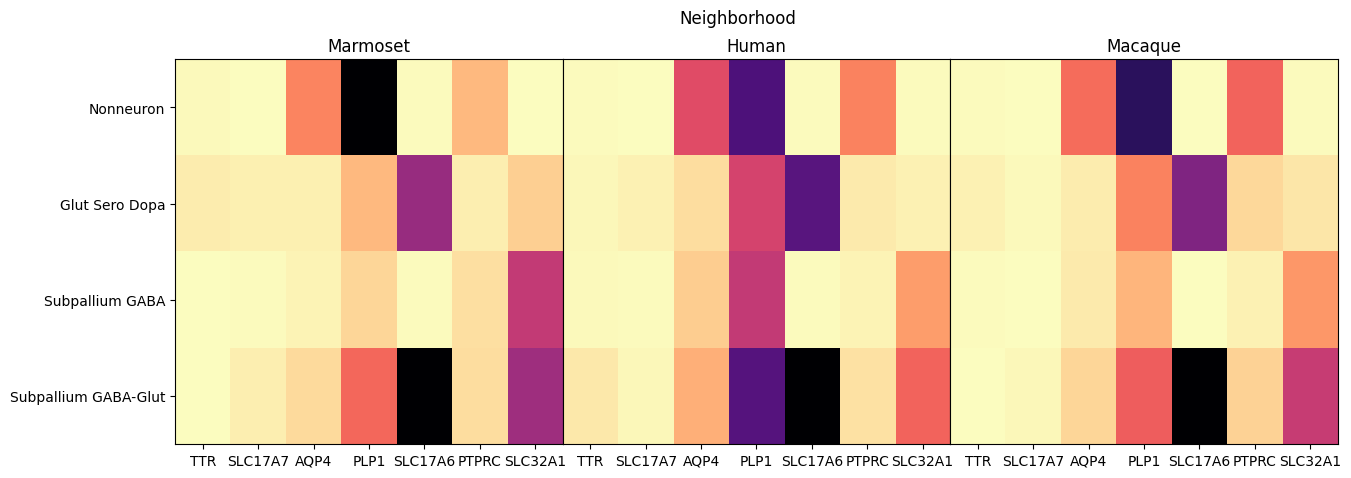

In [160]:
fig, ax = plot_species_heatmap(
    df=cell_extended_with_genes,
    gnames=aligned_gene_data.columns,
    value='Neighborhood',
    fig_width=15,
    fig_height=5
)
fig.suptitle('Neighborhood')
plt.show()

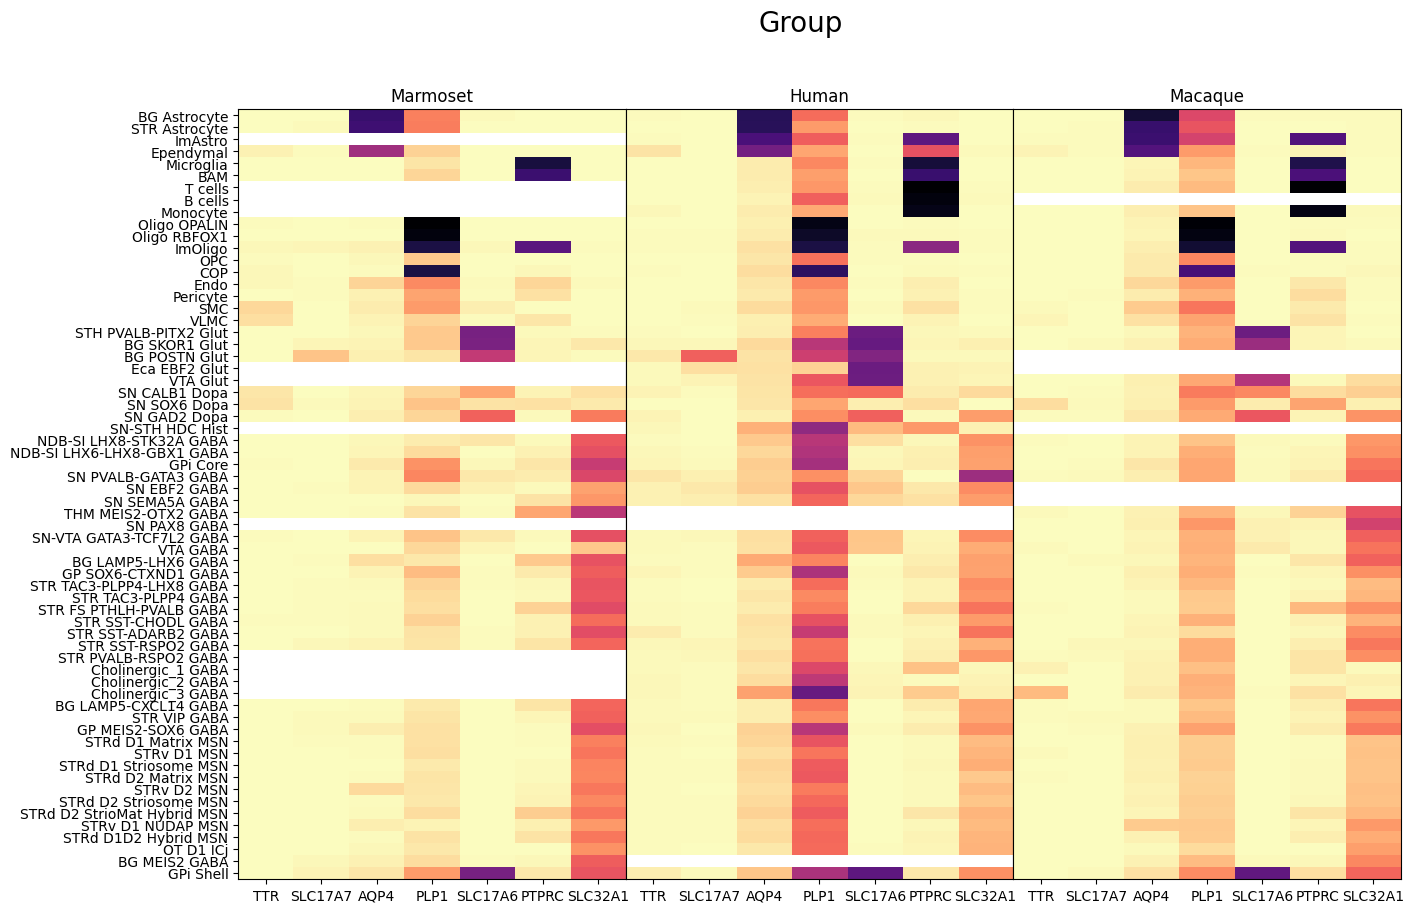

In [161]:
fig, ax = plot_species_heatmap(
    df=cell_extended_with_genes,
    gnames=aligned_gene_data.columns,
    value='Group',
    fig_width=15,
    fig_height=10
)
fig.suptitle('Group', size=20)
plt.show()

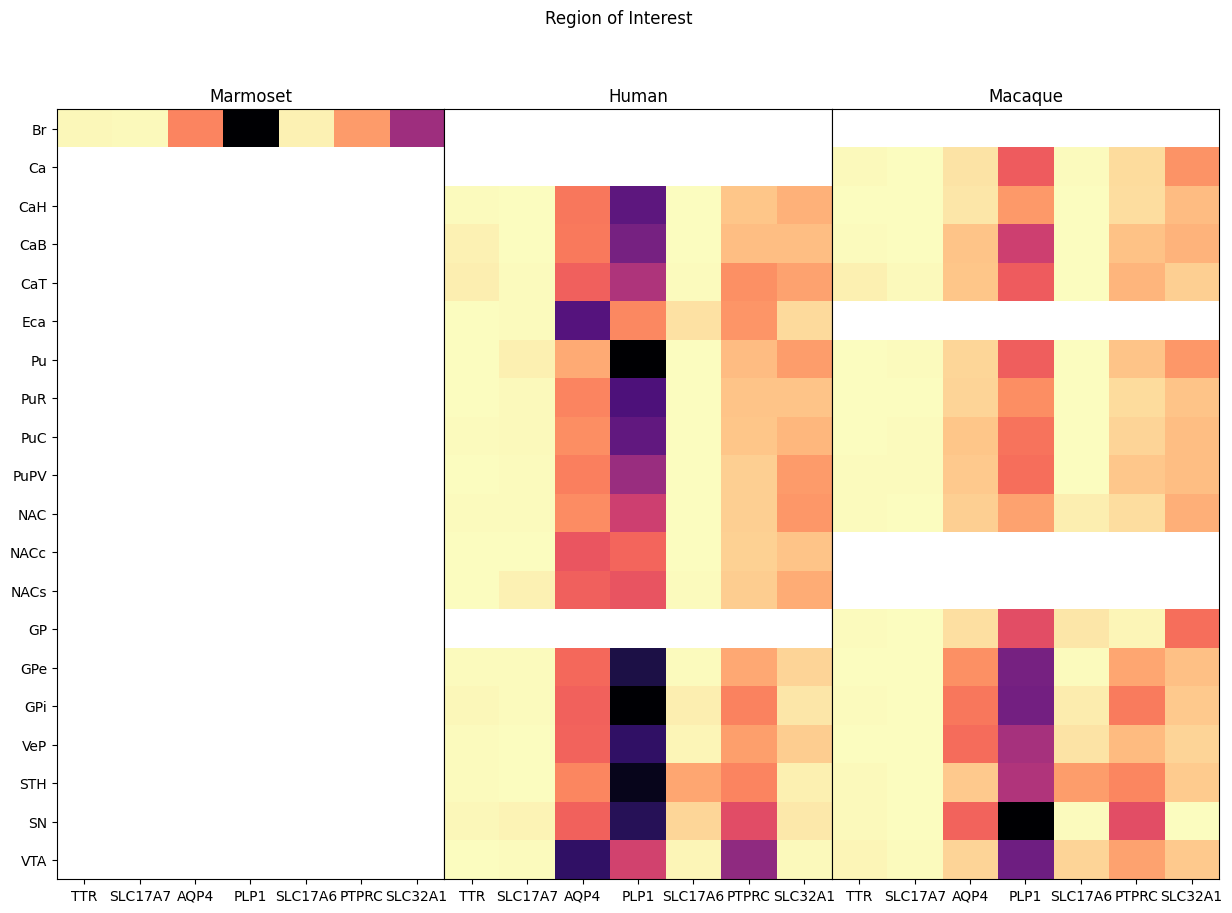

In [162]:
fig, ax = plot_species_heatmap(
    df=cell_extended_with_genes,
    gnames=aligned_gene_data.columns,
    value='region_of_interest_label',
    fig_width=15,
    fig_height=10
)
fig.suptitle('Region of Interest')
plt.show()

## Expression in the UMAP

We can also visualize the relationship between these genes and their location in the UMAP. We'll plot the two species side by side with the grey cells in each plot representing those from the other species that do not overlap with the plotted one. Overall the expressions between species agree across the UMAP.

In [163]:
def plot_umap(df, feature, species_list, cmap=None, fig_width=21, fig_height=10) :
    
    fig, ax = plt.subplots(1, len(species_list))
    fig.set_size_inches(fig_width, fig_height)

    all_xx = df['x']
    all_yy = df['y']
    
    for idx, species in enumerate(species_list):
        
        filtered = df[df['species_common_name'] == species]
        xx = filtered['x']
        yy = filtered['y']
        vv = filtered[feature]

        ax[idx].scatter(all_xx, all_yy, s=1.0, color='#D3D3D3', marker='.')
        
        if cmap is not None :
            ax[idx].scatter(xx, yy, s=1.0, c=vv, marker='.', cmap=cmap)
        else :
            ax[idx].scatter(xx, yy, s=1.0, color=vv, marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title(f"{species}")
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax

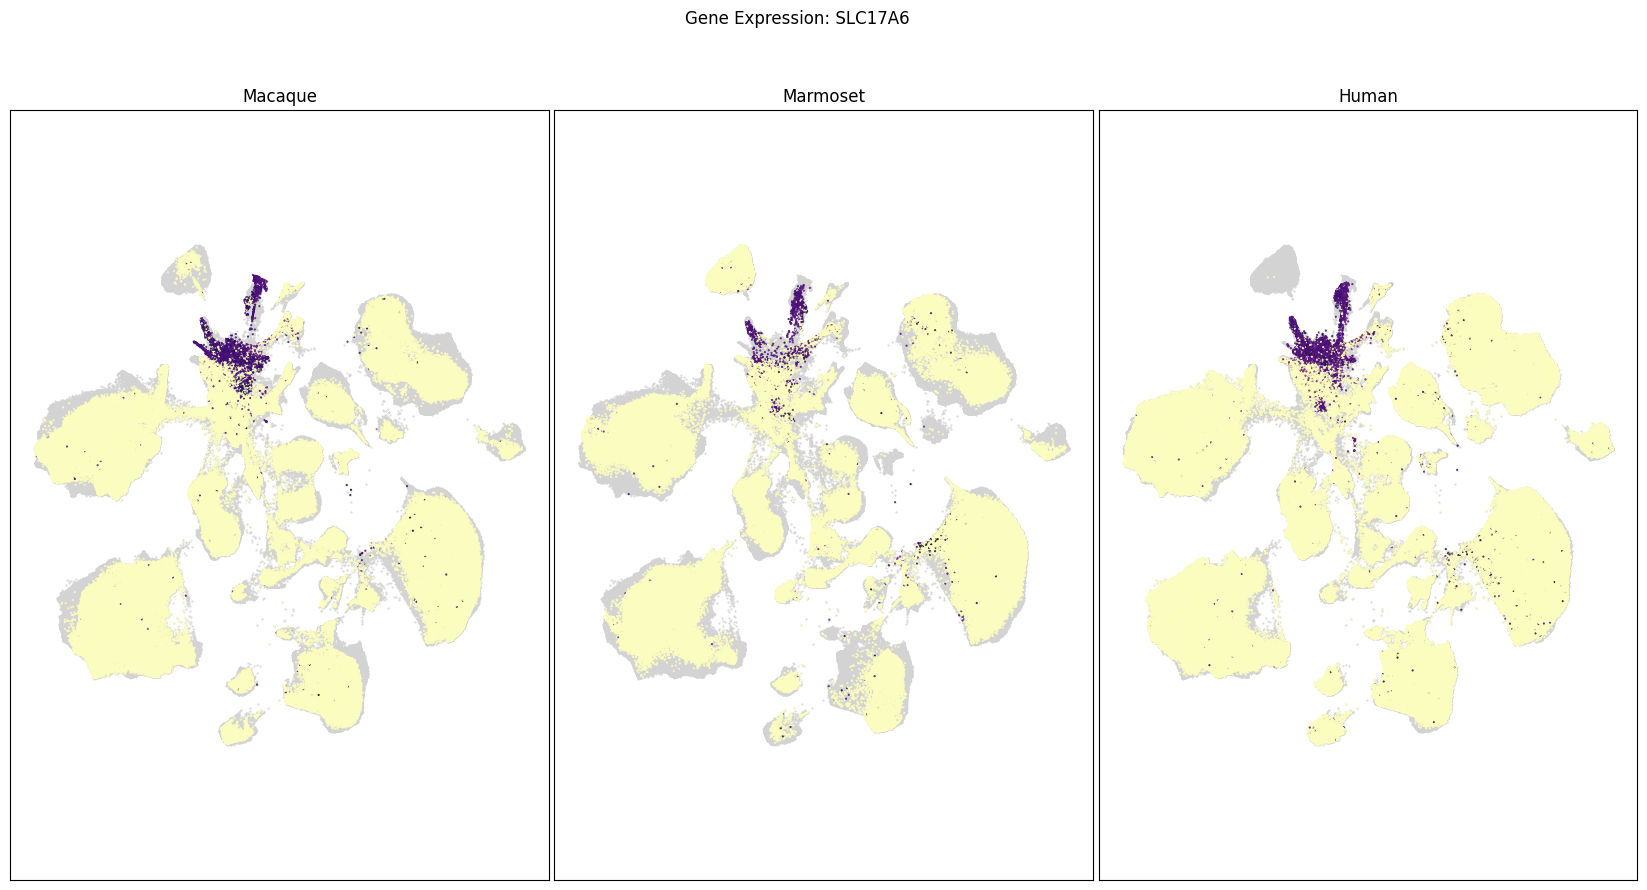

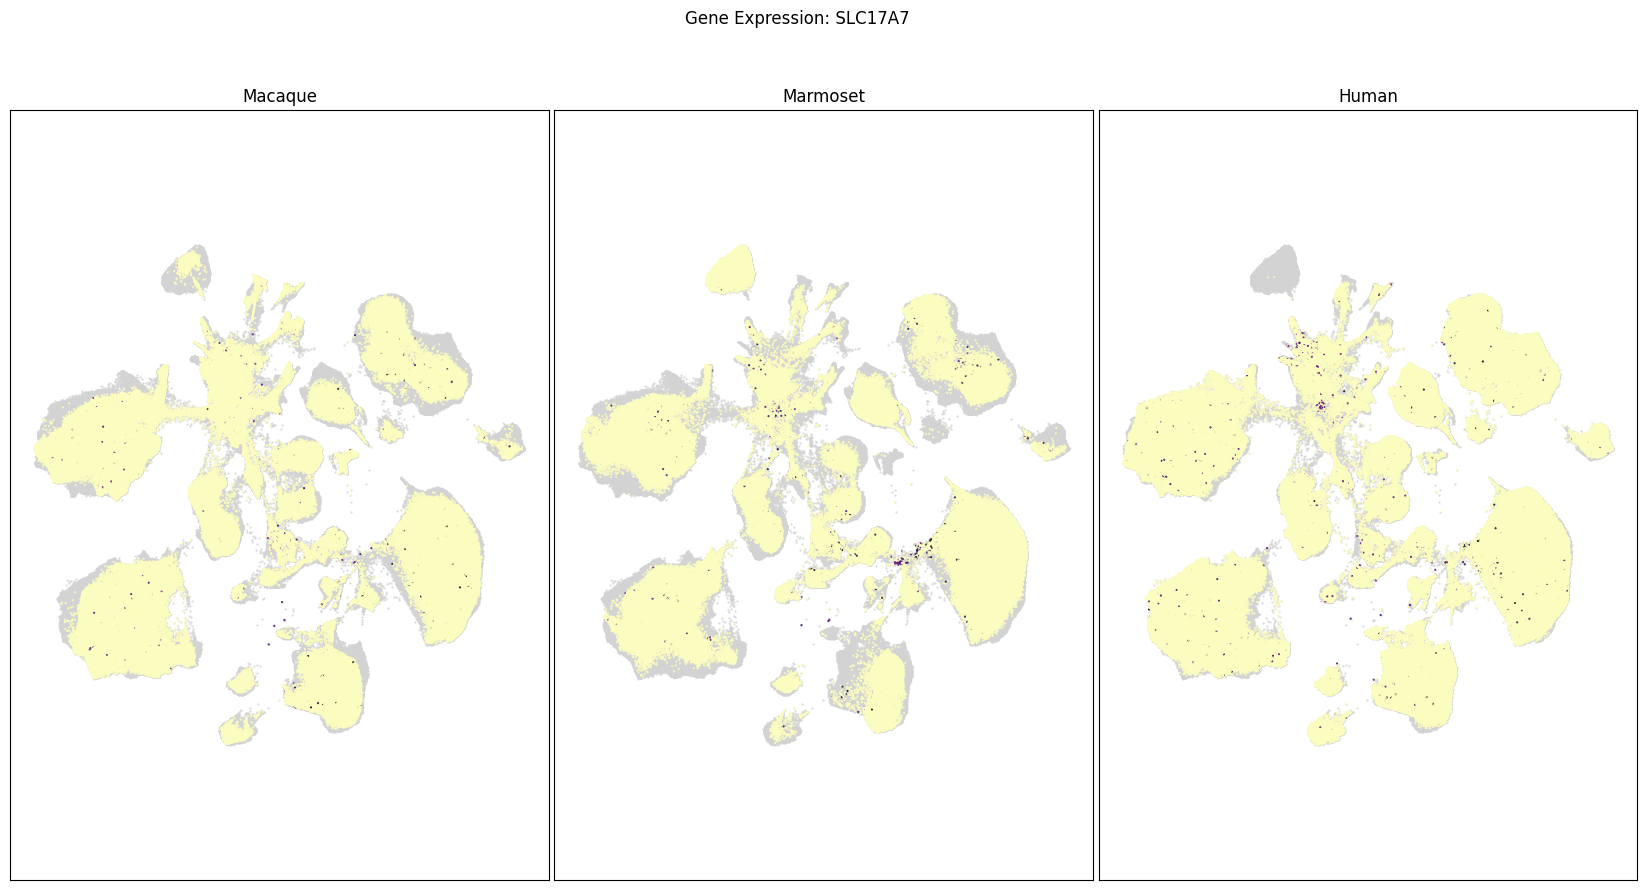

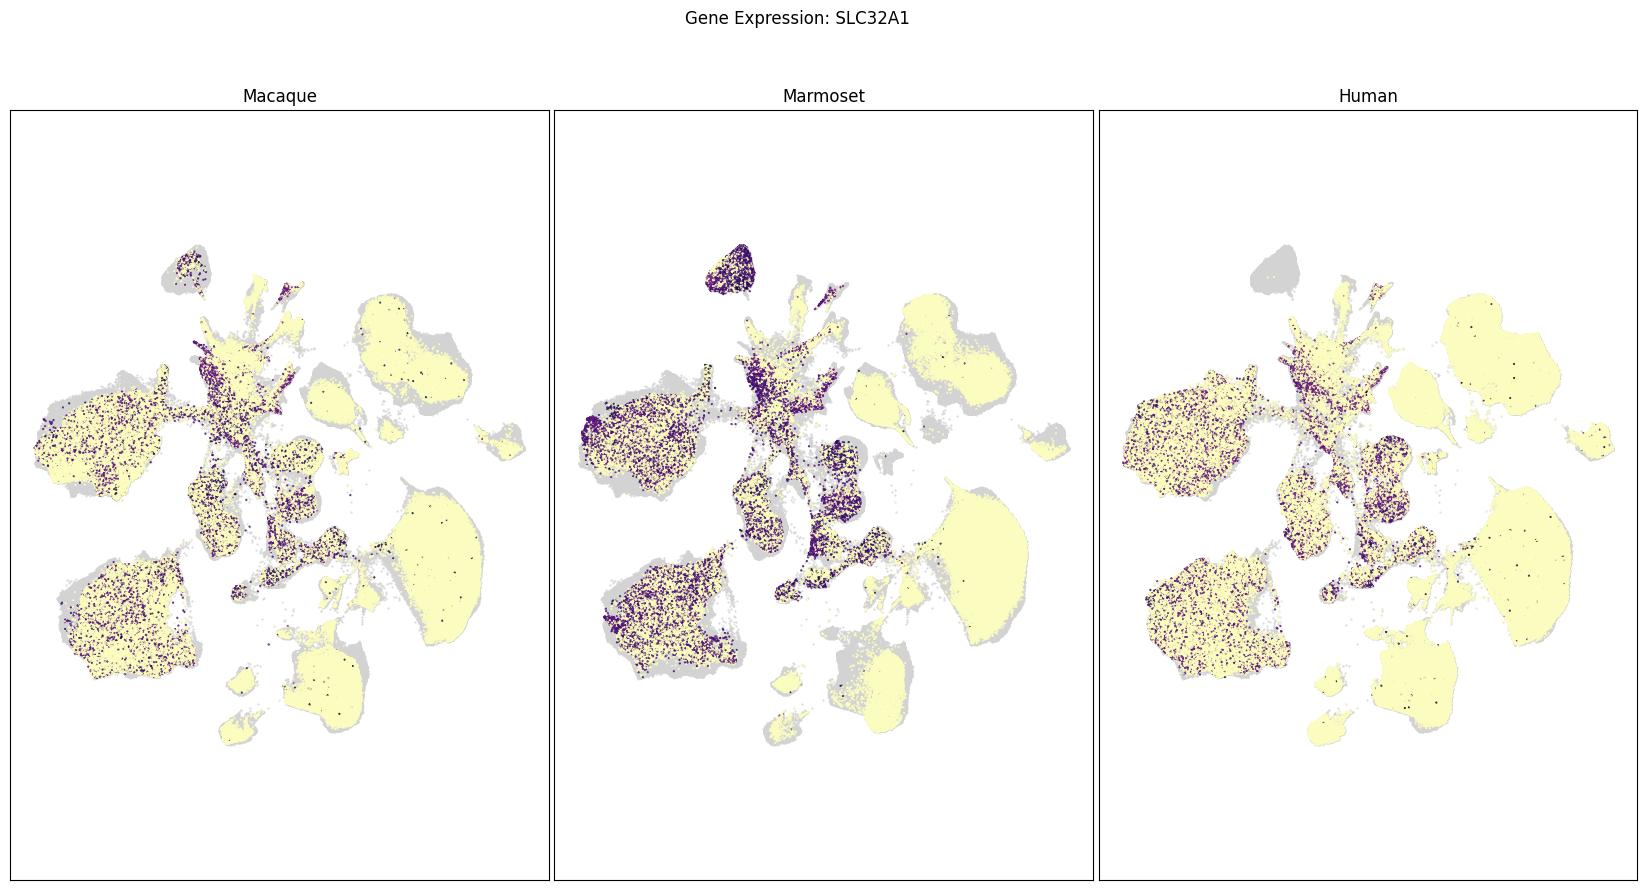

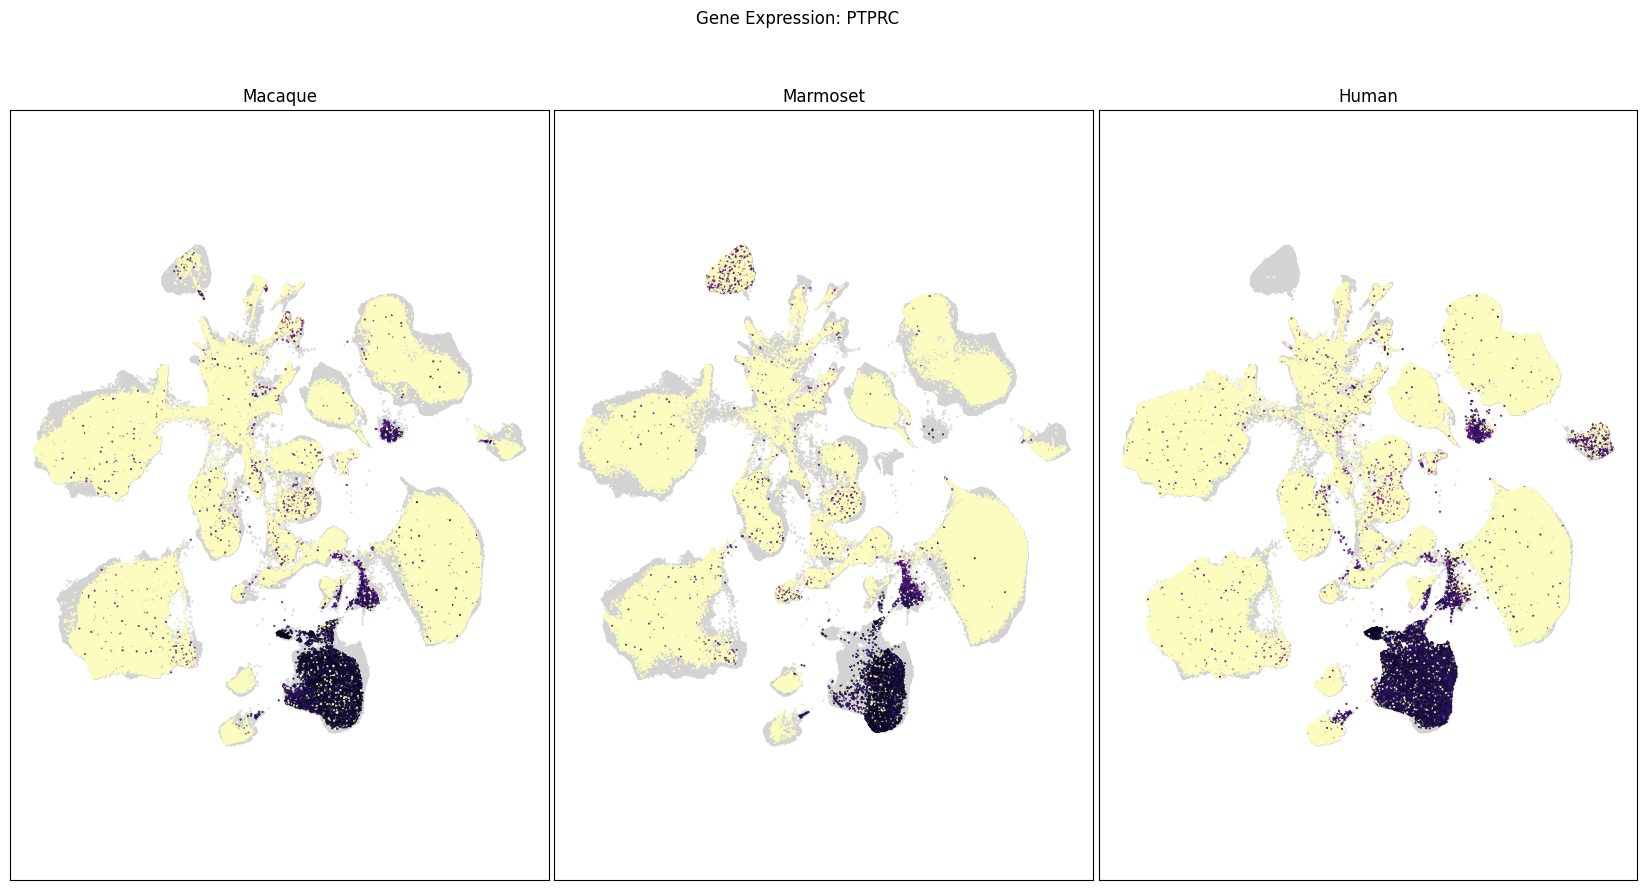

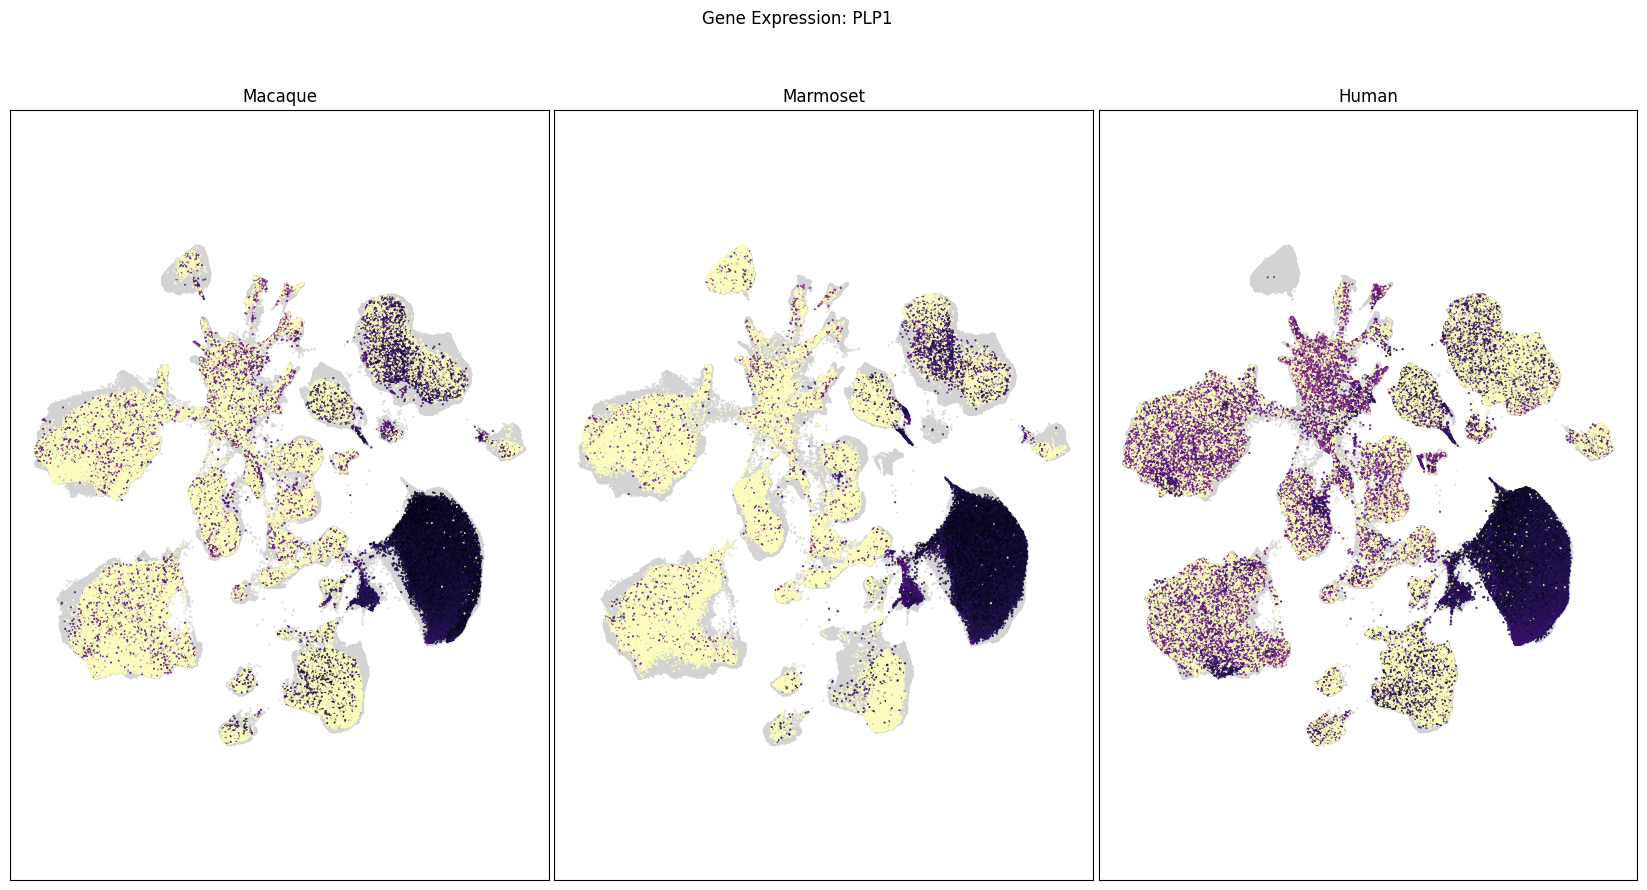

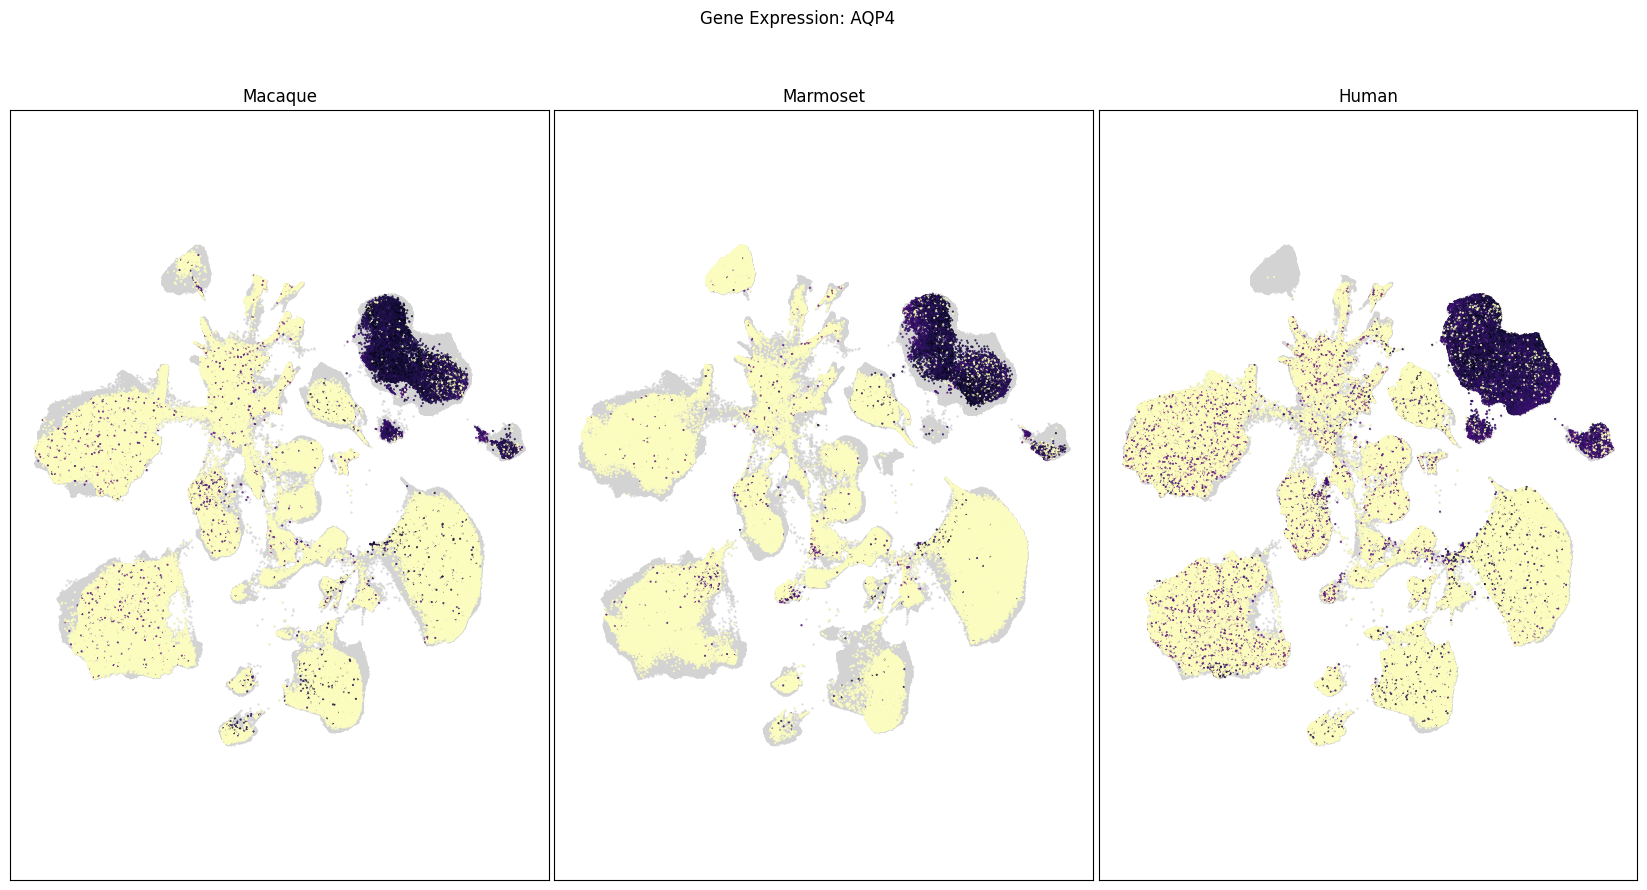

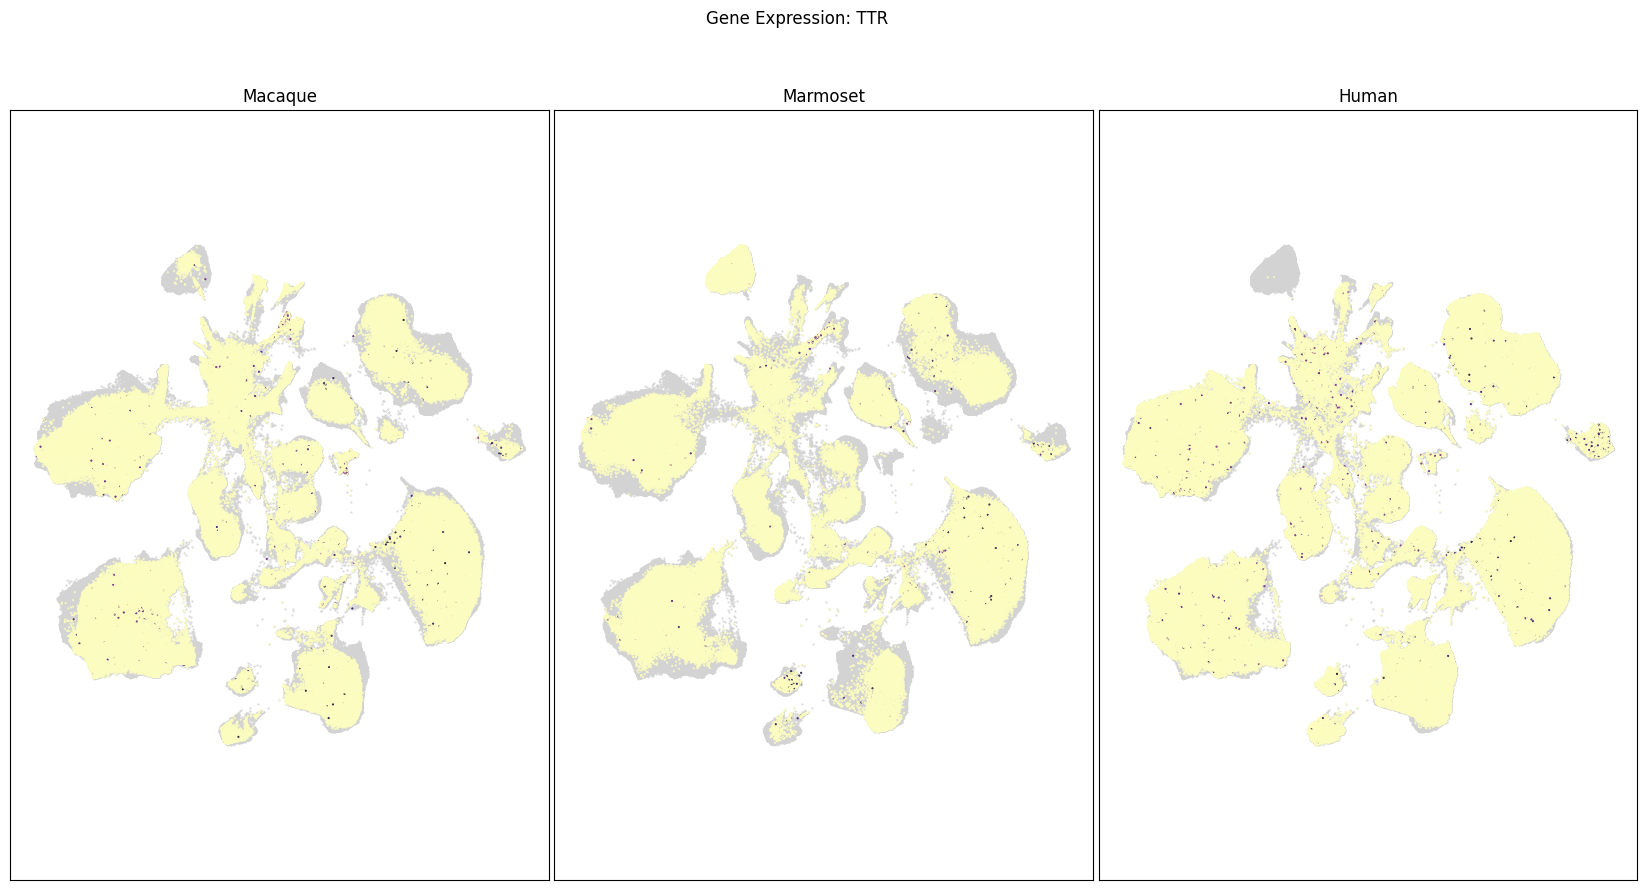

In [164]:
for gene_name in gene_names:
    fig, ax = plot_umap(
        cell_extended_with_genes,
        feature=gene_name,
        species_list=['Macaque', 'Marmoset', 'Human'],
        cmap=plt.cm.magma_r
    )
    fig.suptitle(f'Gene Expression: {gene_name}')
    plt.show()